# Surfboard mPower classification task

Example classification task using Surfboard features, highlighting the importance of keeping train/test sets disjoint by participant and matching age/gender to create meaningful validation metrics.

## Setup

In [1]:
import os
import json

import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    auc,
    roc_curve,
    confusion_matrix,
    classification_report,
)

import pandas as pd
import numpy as np

np.random.seed(123)

We do not provide public access to the following files. Access to mPower data is managed by the Synapase platform. For more information about accessing the dataset, see [this page](https://www.synapse.org/#!Synapse:syn4993293/wiki/247859).

In [2]:
features_csv = 'surfboardfeats_mpower_is2020.csv'
metadata_csv = 'metadata.csv'
balanced_fnames_json = 'test_fnames.json'

## Load/prepare the data

Load Surfboard pre-computed features.

In [3]:
surfboard_output = pd.read_csv(features_csv)

Load tbe metadata.

In [4]:
metadata = pd.read_csv(metadata_csv)
fname_to_diagnosis = {row['fnames']: row['professional-diagnosis'] for _, row in metadata.iterrows()}

In [5]:
def check_fname(fname):
    if fname_to_diagnosis[fname] in [True, False]:
        return True
    return False

Some of the .wav files were missing from the metadata .csv file, and vice versa. Take the intersection then remove the file names that do not have a diagnosis.

In [6]:
retained_fnames = list(set(metadata['fnames']).intersection(set(surfboard_output['fnames'])))
print(f'Retaining {len(retained_fnames)} intermediate fnames...')

retained_fnames = set([f for f in retained_fnames if check_fname(f)])
print(f'Retaining {len(retained_fnames)} fnames...')

# This dictionary will be useful for balancing the validation sets.
diagnosis_to_fnames = {
    'PD': [f for f in retained_fnames if fname_to_diagnosis[f]], 
    'HC': [f for f in retained_fnames if not fname_to_diagnosis[f]]
}

Retaining 63238 intermediate fnames...
Retaining 62831 fnames...


## Define the test sets
All of these will be balanced in terms of diagnosis.

1. Random validation set.

2. Disjoint (in terms of identity) validation set – to ensure we don't just learn characteristics related to participant identity. For this we will pick healthCodes (unique participant identifiers).

3. Matched (in terms of age/gender) and disjoint (in terms of identity) validation set. This has been precomputed.

In [7]:
# 1. Sample 5000 random filenames, making sure that we have 2500 HC and 2500 PD.
random_HC = np.random.choice(diagnosis_to_fnames['HC'], 2500, replace=False)
random_PD = np.random.choice(diagnosis_to_fnames['PD'], 2500, replace=False)
random_validation_fnames = list(random_HC) + list(random_PD)

# 2. Sample some healthCodes.
random_healthcodes = set(np.random.choice(np.unique(metadata['healthCode']), 500, replace=False))
temp_disjoint_fnames = [
    row['fnames'] for _, row in metadata.iterrows() if (row['healthCode'] in random_healthcodes) and row['fnames'] in retained_fnames
]

PDs = [f for f in temp_disjoint_fnames if fname_to_diagnosis[f]]
HCs = [f for f in temp_disjoint_fnames if not fname_to_diagnosis[f]]

num_PDs, num_HCs = 0, 0
disjoint_fnames = []
delete_from_trainset = []

for f in temp_disjoint_fnames:
    if num_PDs < min(len(PDs), len(HCs)) and fname_to_diagnosis[f]:
        num_PDs += 1
        disjoint_fnames.append(f)
    elif num_HCs < min(len(PDs), len(HCs)) and not fname_to_diagnosis[f]:
        num_HCs += 1
        disjoint_fnames.append(f)
    else:
        delete_from_trainset.append(f)

# 3. Load from json.
matched_disjoint_fnames = json.load(open(balanced_fnames_json, 'r'))

## Define the training set

In [8]:
validation_fnames = set(random_validation_fnames).union(set(disjoint_fnames)).union(set(matched_disjoint_fnames))
train_fnames = [f for f in retained_fnames if (f not in validation_fnames and f not in delete_from_trainset)]

In [9]:
def preprocess_features(X):
    """X is a pandas DataFrame. We replace the inf and nan entries
    with column means."""
    X = np.array(X)
    
    # Replace infs by NaNs.
    X[np.where(np.isinf(X))] = float('nan')

    # Replace NaNs by column means.
    nan_mean = np.nanmean(X, 0)
    nans = np.where(pd.isnull(X))

    for row_idx, col_idx in zip(nans[0], nans[1]):
        X[row_idx, col_idx] = nan_mean[col_idx]
        
    return X

def fnames_to_model_inputs(fnames, column_max=None):
    feats = surfboard_output[surfboard_output['fnames'].isin(fnames)]
    labels = ['PD' if fname_to_diagnosis[f] else 'HC' for f in feats['fnames']]
    feats = feats.drop('fnames', 1)
    feats = preprocess_features(feats)

    if column_max is None:
        column_max = np.abs(feats).max(0)
        feats = feats / column_max
        return feats, labels, column_max
    
    feats = feats / column_max
    return feats, labels

## Train classifier

In [10]:
train_features, train_labels, col_max = fnames_to_model_inputs(train_fnames)

random_validation_features, random_validation_labels = fnames_to_model_inputs(random_validation_fnames, column_max=col_max)
disjoint_validation_features, disjoint_validation_labels = fnames_to_model_inputs(disjoint_fnames, column_max=col_max)
matched_disjoint_features, matched_disjoint_labels = fnames_to_model_inputs(matched_disjoint_fnames, column_max=col_max)

In [11]:
classifier = GradientBoostingClassifier(verbose=True).fit(train_features, train_labels)

      Iter       Train Loss   Remaining Time 
         1           1.2677            8.92m
         2           1.2424            8.84m
         3           1.2213            8.70m
         4           1.2034            8.67m
         5           1.1876            8.59m
         6           1.1733            8.51m
         7           1.1601            8.40m
         8           1.1498            8.32m
         9           1.1395            8.25m
        10           1.1297            8.16m
        20           1.0592            7.27m
        30           1.0139            6.36m
        40           0.9814            5.46m
        50           0.9563            4.56m
        60           0.9334            3.66m
        70           0.9154            2.74m
        80           0.8984            1.83m
        90           0.8841           54.79s
       100           0.8706            0.00s


## Validate on test sets
Note: the reported metrics below might be slightly different to those reported in the paper as the validation set generation is random.

In [12]:
for name, feats, labels in zip(
    ['Random validation', 'Disjoint random', 'Matched disjoint'],
    [random_validation_features, disjoint_validation_features, matched_disjoint_features],
    [random_validation_labels, disjoint_validation_labels, matched_disjoint_labels]
):
    predictions_valid = classifier.predict(feats)
    cmatrix = confusion_matrix(labels, predictions_valid)
    print(f'{name} classification report: \n{classification_report(labels, predictions_valid)}\n')

Random validation classification report: 
              precision    recall  f1-score   support

          HC       0.87      0.55      0.67      2500
          PD       0.67      0.92      0.78      2500

    accuracy                           0.73      5000
   macro avg       0.77      0.73      0.73      5000
weighted avg       0.77      0.73      0.73      5000


Disjoint random classification report: 
              precision    recall  f1-score   support

          HC       0.84      0.54      0.66      2547
          PD       0.66      0.89      0.76      2547

    accuracy                           0.72      5094
   macro avg       0.75      0.72      0.71      5094
weighted avg       0.75      0.72      0.71      5094


Matched disjoint classification report: 
              precision    recall  f1-score   support

          HC       0.70      0.46      0.55      1000
          PD       0.60      0.80      0.68      1000

    accuracy                           0.63      2000
   

We can see that the metrics get gradually worse as we traverse from random validation to disjoint random validation to matched disjoint, with the biggest jump being from disjoint random to matched disjoint. 

**This suggests that the classifier is exploiting underlying age and gender biases in the data set.**

Let's now take a look at the ROC surves and AUCs.

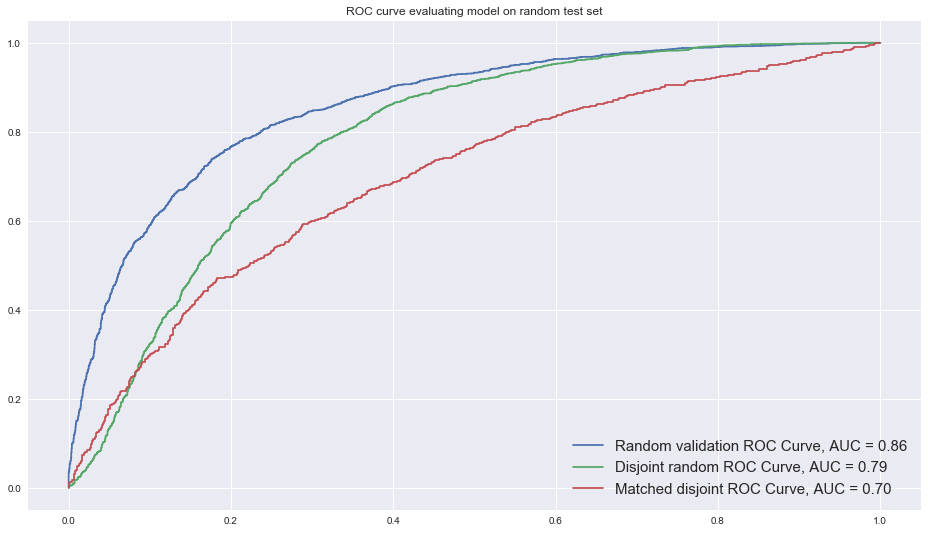

In [13]:
plt.figure(figsize=(16, 9))
for name, feats, labels in zip(
    ['Random validation', 'Disjoint random', 'Matched disjoint'],
    [random_validation_features, disjoint_validation_features, matched_disjoint_features],
    [random_validation_labels, disjoint_validation_labels, matched_disjoint_labels]
):
    prob_predictions_valid = classifier.predict_log_proba(feats)
    fpr, tpr, _ = roc_curve([1 if el == 'PD' else 0 for el in labels], prob_predictions_valid[:, 1])
    plt.plot(fpr, tpr, label='{} ROC Curve, AUC = {:.2f}'.format(name, auc(fpr, tpr)))
    plt.legend(prop={'size': 15})
    plt.title('ROC curve evaluating model on random test set')
plt.show()

This confirms what we observed in the classification reports: the generalisation gets progressively worse as we traverse from random validation to disjoint random to matched disjoint